In [39]:
!git clone https://github.com/thibo73800/capsnet_traffic_sign_classifier.git
!cd capsnet_traffic_sign_classifier.git
!wget https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip
!unzip traffic-signs-data.zip
!mkdir dataset
!mv *.p dataset/
!rm traffic-signs-data.zip

fatal: destination path 'capsnet_traffic_sign_classifier' already exists and is not an empty directory.
/bin/bash: line 0: cd: capsnet_traffic_sign_classifier.git: No such file or directory
--2024-05-13 23:35:57--  https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip
Resolving d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)... 18.172.139.41, 18.172.139.86, 18.172.139.98, ...
Connecting to d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)|18.172.139.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123524425 (118M) [application/zip]
Saving to: 'traffic-signs-data.zip'

traffic-signs-data. 100%[===================>] 117.80M   245MB/s    in 0.5s    

2024-05-13 23:35:57 (245 MB/s) - 'traffic-signs-data.zip' saved [123524425/123524425]

Archive:  traffic-signs-data.zip
  inflating: test.p                  
  inflating: train.p                 
  inflating: valid.p                 


In [40]:
import numpy as np  # Added to use numpy functions

training_file = "dataset/train.p"
validation_file= "dataset/valid.p"
testing_file = "dataset/test.p"

with open(training_file, mode='rb') as f:
    train = np.load(f, allow_pickle=True)
with open(validation_file, mode='rb') as f:
    valid = np.load(f, allow_pickle=True)
with open(testing_file, mode='rb') as f:
    test = np.load(f, allow_pickle=True)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Print the shape of variables
print(X_train.shape)
print(y_train.shape)

n_train = len(X_train)
n_validation = len(X_valid)
n_test = len(X_test)
image_shape = X_train[0].shape

# unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
print(n_train, n_validation, n_test)

(34799, 32, 32, 3)
(34799,)
Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
34799 4410 12630


In [41]:
y_train

array([41, 41, 41, ..., 25, 25, 25], dtype=uint8)

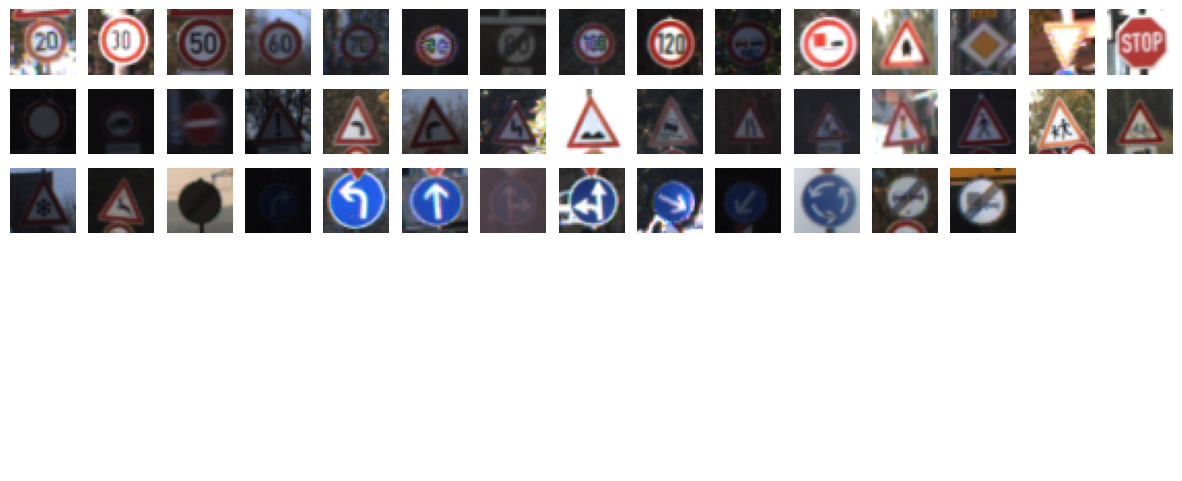

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.image as mpimg
import random

def split_by_class(y_data) :
    """
    Returns a dictionary whose keys are the class labels
    and key values are list of indices with that class label.
    """
    img_index = {}
    labels = set(y_data)
    for i, y in enumerate(y_data):
        if y not in img_index.keys():
            img_index[y] = [i]
        else:
            img_index[y].append(i)
    return img_index

def display_sample_images(X_data, y_data, i_start='random') :
    """
    Displays images from each class,
    i_start is the starting index in each class.
    By default, images are randomly chosen from each class
    """
    img_index = split_by_class(y_data)
    labels = list(set(y_data))[::-1]
    fig, axes = plt.subplots(6, 15, figsize=(15, 6))
    for ax in axes.flatten() :
        if labels : #labels!= 0
            i_img = 0
            if i_start == 'random':
                i_img = random.choice(img_index[labels.pop()])
            else :
                i_img = img_index[labels.pop()][i_start]
            ax.imshow(X_train[i_img])
        ax.axis('off')


display_sample_images(X_train, y_train)



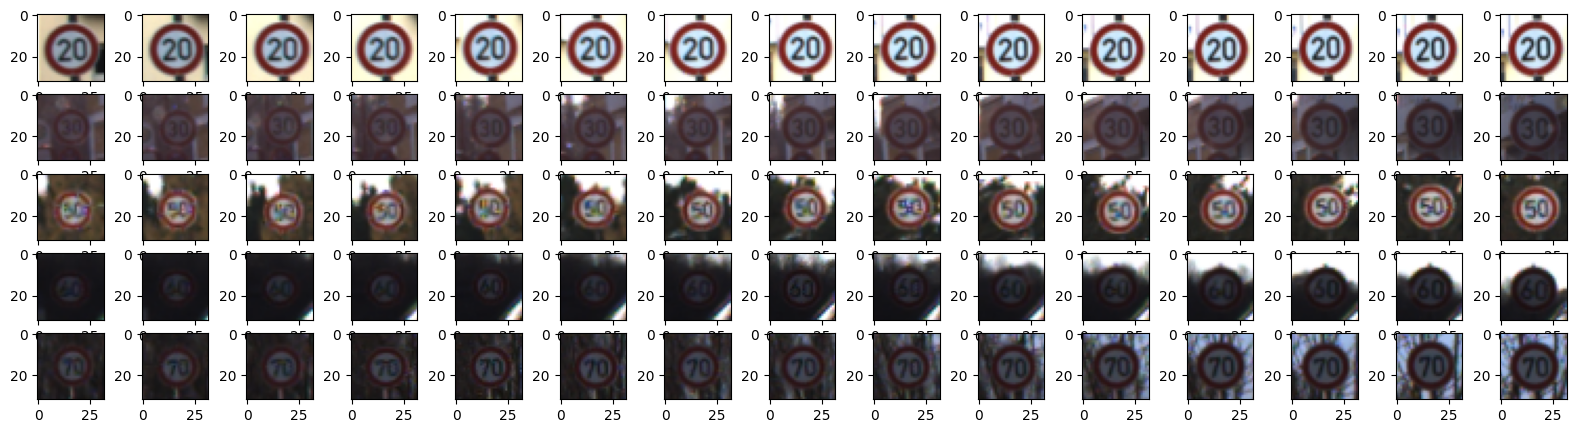

In [43]:

img_index = split_by_class(y_train)
fig, ax = plt.subplots(5,15, figsize=(20,5))
for label in range(5) :
    for i in range(15) :
        ax[label, i].imshow(X_train[img_index[label][i]])
        ax[label, i].axis('on')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


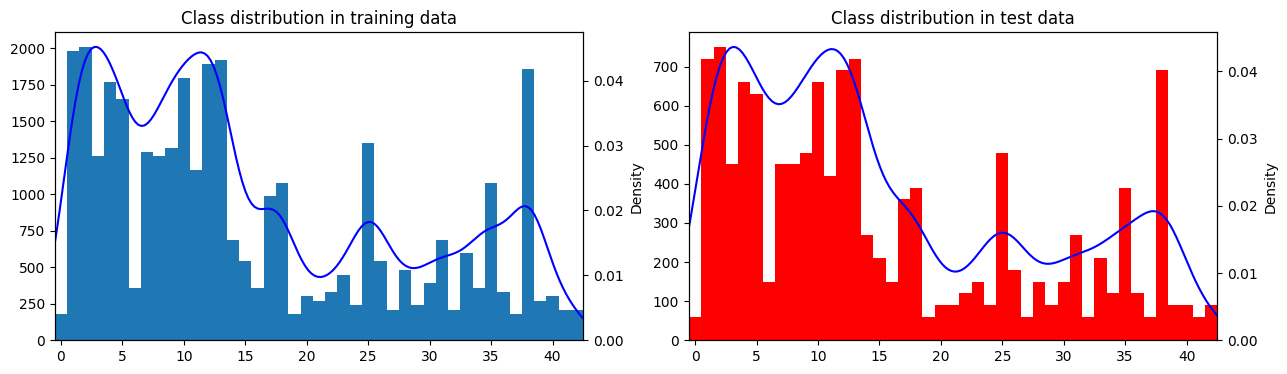

In [44]:
import numpy as np
import seaborn as sns

def plot_dist(y_data, title=None, ax=None, **kwargs) :
    if not ax :
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.hist(y_data, np.arange(-0.5, n_classes+1.5), stacked=True, **kwargs)
    sns.kdeplot(y_data, color='blue', ax=ax.twinx())
    ax.set_xlim(-0.5,n_classes-0.5)
    if 'label' in kwargs : ax.legend()
    if title : ax.set_title(title)

fig,ax = plt.subplots(1,2, figsize=(15,4))
#print(ax[1])
plot_dist(y_train, title='Class distribution in training data', ax=ax[0])
plot_dist(y_test, title='Class distribution in test data', ax=ax[1], color='red')

Text(0.5, 1.0, 'Contrast norm.')

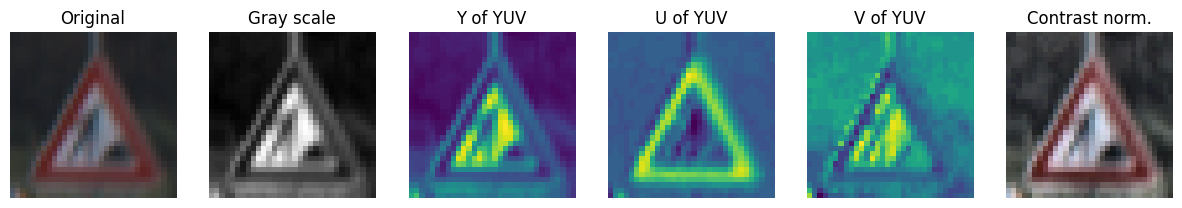

In [45]:
import cv2
import random
from sklearn.utils import shuffle

def MinMaxNorm(image, a=-.5, b=.5) :
    Xmin, Xmax = np.min(image), np.max(image)
    return (image-Xmin)*(b-a)/(Xmax-Xmin)

def AbsNorm(image, a=-.5, b=0.5, col_min=0, col_max=255) :
    return (image-col_min)*(b-a)/(col_max-col_min)

def grayscale_norm(image) :
    # convert to grayscale
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return MinMaxNorm(img)

def YUV_norm(image) :
    # convert to YUV color space
    new_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    # normalize the Y channel
    [y,u,v] = [new_image[:,:,i] for i in range(3)]
    new_image = np.zeros(image.shape)
    new_image[:,:,0] = MinMaxNorm(y)
    new_image[:,:,1],new_image[:,:,2] = AbsNorm(u), AbsNorm(v)
    return new_image
def contrast_norm(image) :
    # convert to  lab colorspace
    lab= cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    # apply adative histogram equalization
    l = lab[:,:,0]
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(4,4))
    cl = clahe.apply(l)
    lab[:,:,0] = cl
    # convert back to RGB and scale values
    img =  cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    new_img = np.zeros(image.shape)
    for i in range(3) :
        new_img[:,:,i] = AbsNorm(img[:,:,i])
    return new_img

img_index = split_by_class(y_train)
img = X_train[img_index[25][20]]
fig, ax = plt.subplots(1,6, figsize=(15,3))
for axes in ax :
    axes.axis('off')

# original image
ax[0].imshow(img)
ax[0].set_title('Original')
# grayscale normalized
ax[1].imshow(grayscale_norm(img), cmap='gray')
ax[1].set_title('Gray scale')
# YUV normalized (Y channel)
ax[2].imshow(YUV_norm(img)[:,:,0])
ax[2].set_title('Y of YUV')
# YUV normalized (U channel)
ax[3].imshow(YUV_norm(img)[:,:,1])
ax[3].set_title('U of YUV')
# YUV normalized (V channel)
ax[4].imshow(YUV_norm(img)[:,:,2])
ax[4].set_title('V of YUV')
# Contrast normalized
ax[5].imshow(contrast_norm(img))
ax[5].set_title('Contrast norm.')

In [46]:
from sklearn.model_selection import train_test_split

def split_train_validation(X_data, y_data) :
    # Initialize lists to store training and validation data
    X_train_new, y_train_new = [], []
    X_validation, y_validation = [], []

    n_per_track = 30  # Images per track
    img_index = split_by_class(y_data)

    for label in range(n_classes):
        indices = img_index[label]
        n_tracks = round(len(indices) / n_per_track)  # Number of tracks for this label

        # Split the data into tracks
        X_list = np.array_split(X_data[indices[0]:indices[-1] + 1], n_tracks)
        y_list = np.array_split(y_data[indices[0]:indices[-1] + 1], n_tracks)

        # Shuffled the tracks
        X_list, y_list = shuffle(X_list, y_list, random_state=0)

        # Separating the first track as validation data, rest as training data
        X_validation.append(X_list[0])
        y_validation.append(y_list[0])
        X_train_new += X_list[1:]
        y_train_new += y_list[1:]

    return (np.concatenate(X_train_new), np.concatenate(y_train_new),
            np.concatenate(X_validation), np.concatenate(y_validation))

def split_train_validation_alt(X_data, y_data):
    X_train, X_validation, y_train, y_validation = train_test_split(X_data, y_data, test_size=0.1, random_state=0, stratify=y_data)
    return X_train, y_train, X_validation, y_validation

X_train_new, y_train_new, X_validation, y_validation = split_train_validation(X_train, y_train)
print("New training data shape is : ", X_train_new.shape)
print("Validation data shape is : ", X_validation.shape)

New training data shape is :  (33509, 32, 32, 3)
Validation data shape is :  (1290, 32, 32, 3)


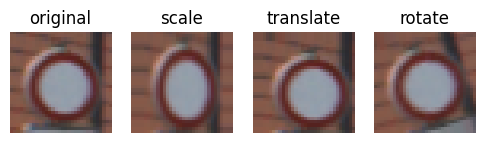

In [47]:
def scale(img, x_scale=0.85, y_scale=1.15):
    # Keeping original dimensions for consistency
    r_orig, c_orig = img.shape[:-1]
    scaled_img = cv2.resize(img, None, fx=x_scale, fy=y_scale)
    # constant padding size
    padded_img = cv2.copyMakeBorder(scaled_img, 5, 5, 5, 5, cv2.BORDER_REPLICATE)
    # Adjusted return values for padding consistency
    r_pad, c_pad = padded_img.shape[:-1]
    r_start, c_start = (r_pad - r_orig) // 2, (c_pad - c_orig) // 2
    return padded_img[r_start:r_start + r_orig, c_start:c_start + c_orig]  # Updated indexing

def translate(img, delta_x=2, delta_y=-2):
    r_orig, c_orig = img.shape[:-1]
    padded_img = cv2.copyMakeBorder(img, 5, 5, 5, 5, cv2.BORDER_REPLICATE)
    # Adjusted return values for padding consistency
    r_pad, c_pad = padded_img.shape[:-1]
    r_start, c_start = (r_pad - r_orig) // 2 + delta_y, (c_pad - c_orig) // 2 - delta_x
    return padded_img[r_start:r_start + r_orig, c_start:c_start + c_orig]  # Updated indexing

def rotate(img, theta=18):
    r_orig, c_orig = img.shape[:-1]
    padded_img = cv2.copyMakeBorder(img, 5, 5, 5, 5, cv2.BORDER_REPLICATE)
    # rotation around the center of the image
    r_pad, c_pad = padded_img.shape[:-1]  # Renamed variables for clarity
    rotation_matrix = cv2.getRotationMatrix2D((c_pad / 2, r_pad / 2), theta, 1)  # Updated center coordinates
    rotated_img = cv2.warpAffine(padded_img, rotation_matrix, (c_pad, r_pad))  # Adjusted image size
    # Adjusted return values for padding consistency
    r_start, c_start = (r_pad - r_orig) // 2, (c_pad - c_orig) // 2  # Renamed variables for clarity
    return rotated_img[r_start:r_start + r_orig, c_start:c_start + c_orig]  # Updated indexing


# check if the transformations work
img = X_train[img_index[15][200]]
def original(img) : return img
fig, ax = plt.subplots(1,4, figsize=(6,2))
for i,transform in enumerate([original, scale, translate, rotate]) :
    ax[i].imshow(transform(img))
    ax[i].axis('off')
    ax[i].set_title(transform.__name__)

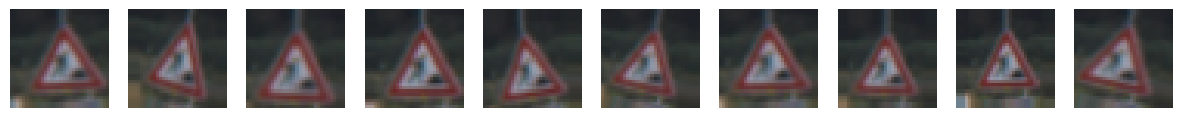

In [48]:
random_scale = lambda img : scale(img, x_scale=random.uniform(0.85, 1.1), y_scale=random.uniform(0.85, 1.1))
random_translate = lambda img : translate(img, delta_x=random.randint(-2, 2), delta_y=random.randint(-2, 2))
random_rotate = lambda img : rotate(img, theta=random.uniform(-17., 17.))

def random_transform(img):
    new_img = img.copy()
    transform_list = [random_scale, random_translate, random_rotate]
    random.shuffle(transform_list)
    for transform in transform_list:
        new_img = transform(new_img)
    return new_img

# check
img = X_train[img_index[25][10]]
fig, ax = plt.subplots(1,10, figsize=(15,2))
for i in range(10) :
    ax[i].imshow(random_transform(img))
    ax[i].axis('off')

In [49]:
from tqdm import tqdm

def perturb_data(X_data, y_data):
    """
    Splits the dataset retaining half the original images
    while perturbing the other half of the images.
    """
    X_original, y_original = [], []
    X_perturbed, y_perturbed = [], []
    num_images = len(X_data)
    with tqdm(total=num_images, unit=' images', desc='Original data perturbation') as images_pbar:
        for i, img in enumerate(X_data):
            if i % 2 == 0:
                X_original.append(img)
                y_original.append(y_data[i])
            else:
                X_perturbed.append(random_transform(img))
                y_perturbed.append(y_data[i])
            images_pbar.update(1)
    return np.array(X_original), np.array(y_original), np.array(X_perturbed), np.array(y_perturbed)

def augment_data(X_data, y_data, n=300):
    """
    Augments the dataset so that there are n images per class.
    """
    X_augmented, y_augmented = [], []
    class_indices = split_by_class(y_data)
    num_classes = len(class_indices)
    with tqdm(total=num_classes, unit=' classes', desc='Data augmentation') as class_pbar:
        for label, indices in class_indices.items():
            num_images_label = len(indices)
            print(num_images_label)  # Check for all 43 labels
            n_augmented = n - num_images_label
            if n_augmented <= 0:
                continue
            for _ in range(n_augmented):
                i_img = random.choice(indices)
                img = X_data[i_img]
                X_augmented.append(random_transform(img))
                y_augmented.append(label)
            class_pbar.update(1)
    return np.array(X_augmented), np.array(y_augmented)


In [50]:
from time import sleep
print('Training dataset augmentation')
sleep(1)
X_train_given, y_train_given, X_train_pert, y_train_pert = perturb_data(X_train_new, y_train_new)
X_train_fake, y_train_fake = augment_data(X_train_new, y_train_new, n=5000)
del X_train_new, y_train_new


Training dataset augmentation


Data augmentation:   0%|          | 0/43 [00:00<?, ? classes/s]

150


Data augmentation:   5%|▍         | 2/43 [00:00<00:09,  4.11 classes/s]

1950
1980


Data augmentation:   7%|▋         | 3/43 [00:00<00:08,  4.59 classes/s]

1230


Data augmentation:  12%|█▏        | 5/43 [00:01<00:08,  4.63 classes/s]

1740
1620


Data augmentation:  14%|█▍        | 6/43 [00:01<00:07,  4.65 classes/s]

330


Data augmentation:  16%|█▋        | 7/43 [00:01<00:08,  4.18 classes/s]

1260


Data augmentation:  19%|█▊        | 8/43 [00:01<00:08,  4.19 classes/s]

1230


Data augmentation:  21%|██        | 9/43 [00:02<00:08,  4.22 classes/s]

1290


Data augmentation:  26%|██▌       | 11/43 [00:02<00:07,  4.48 classes/s]

1770
1140


Data augmentation:  30%|███       | 13/43 [00:02<00:06,  4.58 classes/s]

1860
1890


Data augmentation:  33%|███▎      | 14/43 [00:03<00:06,  4.69 classes/s]

660


Data augmentation:  35%|███▍      | 15/43 [00:03<00:06,  4.31 classes/s]

510


Data augmentation:  37%|███▋      | 16/43 [00:03<00:06,  3.99 classes/s]

330


Data augmentation:  40%|███▉      | 17/43 [00:04<00:06,  3.79 classes/s]

960


Data augmentation:  42%|████▏     | 18/43 [00:04<00:06,  3.70 classes/s]

1050


Data augmentation:  44%|████▍     | 19/43 [00:04<00:06,  3.72 classes/s]

150


Data augmentation:  47%|████▋     | 20/43 [00:04<00:06,  3.55 classes/s]

270


Data augmentation:  49%|████▉     | 21/43 [00:05<00:06,  3.50 classes/s]

240


Data augmentation:  51%|█████     | 22/43 [00:05<00:06,  3.46 classes/s]

300


Data augmentation:  53%|█████▎    | 23/43 [00:05<00:05,  3.44 classes/s]

420


Data augmentation:  56%|█████▌    | 24/43 [00:06<00:05,  3.45 classes/s]

210


Data augmentation:  58%|█████▊    | 25/43 [00:06<00:05,  3.40 classes/s]

1320


Data augmentation:  60%|██████    | 26/43 [00:06<00:04,  3.62 classes/s]

510


Data augmentation:  63%|██████▎   | 27/43 [00:06<00:04,  3.58 classes/s]

180


Data augmentation:  65%|██████▌   | 28/43 [00:07<00:04,  3.46 classes/s]

450


Data augmentation:  67%|██████▋   | 29/43 [00:07<00:04,  3.42 classes/s]

210


Data augmentation:  70%|██████▉   | 30/43 [00:07<00:03,  3.31 classes/s]

360


Data augmentation:  72%|███████▏  | 31/43 [00:08<00:03,  3.33 classes/s]

660


Data augmentation:  74%|███████▍  | 32/43 [00:08<00:03,  3.40 classes/s]

180


Data augmentation:  77%|███████▋  | 33/43 [00:08<00:02,  3.35 classes/s]

569


Data augmentation:  79%|███████▉  | 34/43 [00:08<00:02,  3.40 classes/s]

330


Data augmentation:  81%|████████▏ | 35/43 [00:09<00:02,  3.38 classes/s]

1050


Data augmentation:  84%|████████▎ | 36/43 [00:09<00:01,  3.53 classes/s]

300


Data augmentation:  86%|████████▌ | 37/43 [00:09<00:01,  3.49 classes/s]

150


Data augmentation:  88%|████████▊ | 38/43 [00:10<00:01,  3.42 classes/s]

1830


Data augmentation:  91%|█████████ | 39/43 [00:10<00:01,  3.76 classes/s]

240


Data augmentation:  93%|█████████▎| 40/43 [00:10<00:00,  3.63 classes/s]

270


Data augmentation:  95%|█████████▌| 41/43 [00:10<00:00,  3.54 classes/s]

180


Data augmentation:  98%|█████████▊| 42/43 [00:11<00:00,  3.43 classes/s]

180


Data augmentation: 100%|██████████| 43/43 [00:11<00:00,  3.71 classes/s]


In [51]:
import numpy as np

# Randomly pick 10,000 indices
indices = np.random.choice(len(X_train_fake), size=10000, replace=False)

# Select corresponding samples from X_train_fake and y_train_fake
X_train_selected = X_train_fake[indices]
y_train_selected = y_train_fake[indices]

# Save selected data into NPZ file
np.savez('selected_data.npz', X_train_selected=X_train_selected, y_train_selected=y_train_selected)


In [52]:
from time import sleep
print('Testing dataset augmentation')
sleep(1)
X_test_given, y_test_given, X_test_pert, y_test_pert = perturb_data(X_test, y_test)
# X_test_augmented, y_test_augmented = augment_data(X_test, y_test, n=5000)  # Assuming you want to augment with 5000 samples


Testing dataset augmentation


Original data perturbation: 100%|██████████| 12630/12630 [00:00<00:00, 30629.08 images/s]


In [53]:
print(X_test_pert.shape)

(6315, 32, 32, 3)


In [54]:
import numpy as np

# Save augmented test dataset into a NPZ file
np.savez('augmented_test_dataset.npz', X_test_pert=X_test_pert, y_test_pert=y_test_pert)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


(16755,)
(16754,)
(181491,)


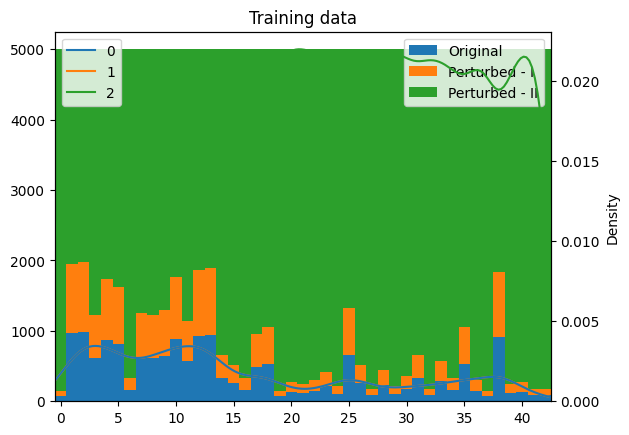

In [55]:
plot_dist([y_train_given,y_train_pert, y_train_fake], title='Training data', \
          label=['Original','Perturbed - I','Perturbed - II'])
print(y_train_given.shape)
print(y_train_pert.shape)
print(y_train_fake.shape)

In [56]:
from sklearn.utils import shuffle
from time import sleep

# combine training data, shuffle and apply pre-processing
print('Preparing training data...')
X_train = np.concatenate((X_train_given, X_train_pert, X_train_fake))
print(X_train.shape)
y_train = np.concatenate((y_train_given, y_train_pert, y_train_fake))
print(y_train.shape)
X_train, y_train = shuffle(X_train, y_train)
del X_train_given, X_train_pert, X_train_fake, \
    y_train_given, y_train_pert, y_train_fake # free memory
sleep(1)
images_pbar = tqdm(X_train, unit='images')
X_train = np.zeros(X_train.shape)
for i,img in enumerate(images_pbar) :
    X_train[i] = contrast_norm(img)
print('Done')

# combine validation data, shuffle and apply pre-processing
print('Preparing validation data...')
X_validation, y_validation = shuffle(X_validation, y_validation)
sleep(1)
images_pbar = tqdm(X_validation, unit='images')
X_validation = np.zeros(X_validation.shape)
for i,img in enumerate(images_pbar) :
    X_validation[i] = contrast_norm(img)
print('Done')

# pre-process test set images
print('Preparing test data...')
sleep(1)
images_pbar = tqdm(X_test, unit='images')
X_test = np.zeros(X_test.shape)
for i,img in enumerate(images_pbar) :
    X_test[i] = contrast_norm(img)
sleep(1)

Preparing training data...
(215000, 32, 32, 3)
(215000,)


100%|██████████| 215000/215000 [00:53<00:00, 4012.34images/s]


Done
Preparing validation data...


100%|██████████| 1290/1290 [00:00<00:00, 4372.25images/s]


Done
Preparing test data...


100%|██████████| 12630/12630 [00:02<00:00, 4395.40images/s]


In [57]:
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from keras.utils import to_categorical
from keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout

In [59]:
from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test= train_test_split(data, labels, test_size= 0.1, random_state=10)

print("training_shape: ", X_train.shape,y_train.shape)
print("testing_shape: ", X_test.shape,y_test.shape)

y_train = tf.one_hot(y_train,43)
y_test = tf.one_hot(y_test,43)

training_shape:  (215000, 32, 32, 3) (215000,)
testing_shape:  (12630, 32, 32, 3) (12630,)


In [60]:


#building the CNN Model
#Adding a Convnet of 32 filters and relu activation
#Adding a Convnet of 32 filters and relu activation
#Adding a Maxpool Layer of (2,2)
#Adding Dropout Regularization with rate= 0.25
#Adding a Convnet of 64 filters and relu activation
#Adding a MaxPool layer of (2,2)
#Adding a Dropout Regularization with rate = 0.25
#Flattening the Model
#Dense layer with Tanh activation
#Final Softmax to categorize the data

model = tf.keras.Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5), activation="relu", input_shape= X_train.shape[1:]))
model.add((Conv2D(filters=64, kernel_size=(5,5), activation="relu")))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))
model.add((Conv2D(filters=128,kernel_size=(3,3),activation="relu")))
model.add((MaxPool2D(pool_size=(2,2))))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(rate=0.40))
model.add(Dense(43, activation="softmax"))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [61]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [62]:
epochs = 25
history = model.fit(X_train[:20000], y_train[:20000], epochs=epochs, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/25
 20/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.0231 - loss: 3.7703

W0000 00:00:1715643464.547173     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3042 - loss: 2.5486

W0000 00:00:1715643470.813927     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715643471.761692     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.3048 - loss: 2.5458 - val_accuracy: 0.8790 - val_loss: 0.4354
Epoch 2/25
 26/313 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8212 - loss: 0.6079

W0000 00:00:1715643472.612836     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8433 - loss: 0.5104 - val_accuracy: 0.9241 - val_loss: 0.2561
Epoch 3/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9238 - loss: 0.2469 - val_accuracy: 0.9363 - val_loss: 0.2115
Epoch 4/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9528 - loss: 0.1504 - val_accuracy: 0.9524 - val_loss: 0.1820
Epoch 5/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9599 - loss: 0.1203 - val_accuracy: 0.9560 - val_loss: 0.1787
Epoch 6/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9718 - loss: 0.0870 - val_accuracy: 0.9578 - val_loss: 0.1880
Epoch 7/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9742 - loss: 0.0807 - val_accuracy: 0.9622 - val_loss: 0.1765
Epoch 8/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9784 - loss: 0.0683 - val_accuracy: 0.9509 - val_loss: 0.2068
Epoch 9/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9817 - loss: 0.0564 - val_accuracy: 0.9595 - val_

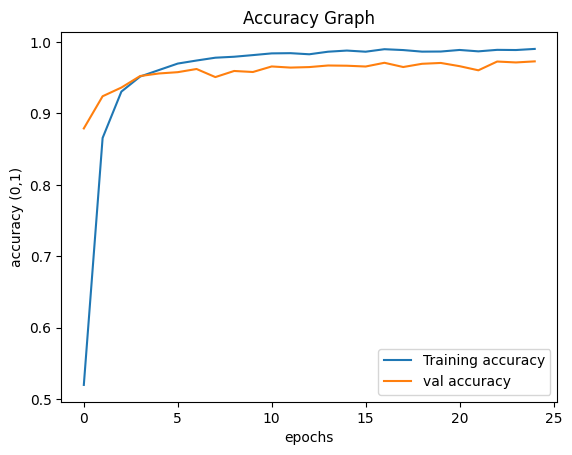

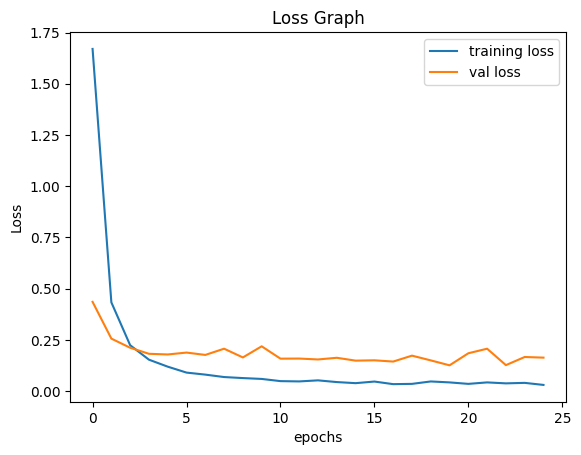

In [63]:
plt.figure(0)
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="val accuracy")
plt.title("Accuracy Graph")
plt.xlabel("epochs")
plt.ylabel("accuracy (0,1)")
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="val loss")
plt.title("Loss Graph")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [64]:
from sklearn.metrics import accuracy_score
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)
print("accuracy: ", accuracy_score(true_classes, predicted_classes))


103/395 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

W0000 00:00:1715643529.044342     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
accuracy:  0.9729216152019002


W0000 00:00:1715643529.906863     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [65]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score

# Obtain predicted probabilities or class predictions from the CNN model
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print("Accuracy: ", accuracy)

# Calculate precision, recall, and F1-score for CNN model
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1)





395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy:  0.9729216152019002
Precision:  0.9738171529678787
Recall:  0.9729216152019002
F1-score:  0.9722808870797548


In [66]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc, average_precision_score



# Compute precision-recall curve and area under the curve (AUC) for each class
precision = dict()
recall = dict()
average_precision = dict()
num_classes = len(np.unique(true_classes))

for i in range(num_classes):  # Assuming num_classes is defined
    precision[i], recall[i], _ = precision_recall_curve(true_classes == i, predicted_classes == i)
    average_precision[i] = average_precision_score(true_classes == i, predicted_classes == i)

# Compute mAP (mean Average Precision)
mAP = np.mean(list(average_precision.values()))
print("mAP:", mAP)

# print(precision)
# print(recall)

mAP: 0.9206080829053845


In [84]:
import cv2
import numpy as np

def preprocess_input(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img_gray, (32, 32))
    img_normalized = img_resized / 255.0
    return img_normalized

def predict_image_label(image_path, model, classes):
    # Read the input image
    input_image = cv2.imread(image_path)
    
    # Preprocess the input image
    preprocessed_input = preprocess_input(input_image)
    
    # Repeat the single channel to create a three-channel image
    preprocessed_input = np.repeat(preprocessed_input[:, :, np.newaxis], 3, axis=2)
    
    # Add batch dimension since the model expects batch input
    preprocessed_input = np.expand_dims(preprocessed_input, axis=0)
    
    # Predict class probabilities
    predicted_probabilities = model.predict(preprocessed_input)
    
    # Get the predicted class label
    predicted_label_index = np.argmax(predicted_probabilities)
    
    # Get the predicted label name
    predicted_label_name = classes[predicted_label_index]
    
    return predicted_label_name



classes = {0: 'Speed limit (20km/h)', 1: 'Speed limit (30km/h)', 2: 'Speed limit (50km/h)', 3: 'Speed limit (60km/h)',
           4: 'Speed limit (70km/h)', 5: 'Speed limit (80km/h)', 6: 'End of speed limit (80km/h)',
           7: 'Speed limit (100km/h)', 8: 'Speed limit (120km/h)', 9: 'No passing',
           10: 'No passing veh over 3.5 tons', 11: 'Right-of-way at intersection', 12: 'Priority road',
           13: 'Yield', 14: 'Stop', 15: 'No vehicles', 16: 'Veh > 3.5 tons prohibited', 17: 'No entry',
           18: 'General caution', 19: 'Dangerous curve left', 20: 'Dangerous curve right', 21: 'Double curve',
           22: 'Bumpy road', 23: 'Slippery road', 24: 'Road narrows on the right', 25: 'Road work',
           26: 'Traffic signals', 27: 'Pedestrians', 28: 'Children crossing', 29: 'Bicycles crossing',
           30: 'Beware of ice/snow', 31: 'Wild animals crossing', 32: 'End speed + passing limits',
           33: 'Turn right ahead', 34: 'Turn left ahead', 35: 'Ahead only', 36: 'Go straight or right',
           37: 'Go straight or left', 38: 'Keep right', 39: 'Keep left', 40: 'Roundabout mandatory',
           41: 'End of no passing', 42: 'End no passing veh > 3.5 tons'}


# Assuming `model` and `classes` are already defined
image_path = "/kaggle/input/images/20.png"
predicted_label_name = predict_image_label(image_path, model, classes)

print("Predicted label:", predicted_label_name)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted label: Traffic signals


In [89]:
import os
def predict_images_in_directory(directory_path, model, classes):
    predicted_labels = []
    image_files = os.listdir(directory_path)
    for image_file in image_files:
        image_path = os.path.join(directory_path, image_file)
        predicted_label_name = predict_image_label(image_path, model, classes)
        predicted_labels.append(predicted_label_name)
    return predicted_labels

# Assuming `model` and `classes` are already defined
directory_path = "/kaggle/input/images"
predicted_labels = predict_images_in_directory(directory_path, model, classes)

# Print the predicted labels for each image
for i, predicted_label in enumerate(predicted_labels):
    print(f"Image {i+1}: Predicted label - {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Image 1: Predicted label - Right-of-way at intersection
Image 2: Predicted label - Traffic signals
Image 3: Predicted label - Veh > 3.5 tons prohibited


In [87]:
# print("Preprocessed input shape:", preprocessed_input.shape)


In [67]:
import cv2
import numpy as np
from google.colab import files
from tensorflow.keras.models import load_model

# Define the preprocessing function
def preprocess_input(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img_gray, (32, 32))
    img_normalized = img_resized / 255.0
    return img_normalized

# Function to upload an image
def upload_image():
    print("Upload an image:")
    uploaded = files.upload()
    if len(uploaded) == 0:
        print("No file uploaded.")
        return None
    else:
        return list(uploaded.keys())[0], uploaded[list(uploaded.keys())[0]]

# Load the trained model
# model = load_model('path_to_your_trained_model.h5')

# Upload the image
image_name, image_content = upload_image()

if image_content:
    # Preprocess the input image
    input_image = cv2.imdecode(np.frombuffer(image_content, np.uint8), -1)
    preprocessed_image = preprocess_input(input_image)
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)  # Add batch dimension

    # Predict the label
    predictions = model.predict(preprocessed_image)
    predicted_class = np.argmax(predictions)

    print("Predicted class for", image_name, ":", predicted_class)


ModuleNotFoundError: No module named 'google.colab'

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from tensorflow.keras.models import load_model

# Define the function for uploading a single image
def upload_image():
    uploaded = files.upload()
    if len(uploaded) == 0:
        print("No file uploaded.")
        return None, None
    else:
        filename, content = next(iter(uploaded.items()))
        return filename, content

# Define the preprocessing function
def preprocess_input(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img_gray, (32, 32))
    img_normalized = img_resized / 255.0
    return img_normalized

# Upload an image
image_name, image_content = upload_image()

if image_content:
    # Preprocess the input image
    input_image = cv2.imdecode(np.frombuffer(image_content, np.uint8), -1)
    preprocessed_image = preprocess_input(input_image)
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)  # Add batch dimension

    # Load the trained model
    model = load_model('path_to_your_trained_model.h5')

    # Make predictions using the trained model
    predictions = model.predict(preprocessed_image)

    # Convert predictions to class labels
    predicted_class = np.argmax(predictions, axis=1)

    # Plot the uploaded image
    plt.imshow(input_image, cmap='gray')
    plt.axis('off')
    plt.show()

    # Print the predicted class
    print("Predicted class:", predicted_class[0])


In [ ]:
from google.colab import files
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
# from google.colab import files

def upload_images():
    print("Choose upload option:")
    print("1. Upload a single image")
    print("2. Upload multiple images")
    print("3. Upload images from a folder")
    choice = input("Enter your choice (1/2/3): ")

    if choice == '1':
        uploaded = files.upload()
    elif choice == '2':
        uploaded = files.upload()
    elif choice == '3':
        uploaded_folder = files.upload()
        folder_name = list(uploaded_folder.keys())[0]
        uploaded = {}
        for filename in os.listdir(folder_name):
            with open(os.path.join(folder_name, filename), 'rb') as f:
                uploaded[filename] = f.read()
    else:
        print("Invalid choice.")
        return None

    return uploaded


def preprocess_input(img):
    img_resized = []
    for image in img:
        resized_img = cv2.resize(image, (32, 32))
        img_resized.append(resized_img)
    img_normalized = np.array(img_resized) / 255.0
    return img_normalized

import matplotlib.pyplot as plt

# Define the classes dictionary
classes = {0: 'Speed limit (20km/h)', 1: 'Speed limit (30km/h)', 2: 'Speed limit (50km/h)', 3: 'Speed limit (60km/h)',
           4: 'Speed limit (70km/h)', 5: 'Speed limit (80km/h)', 6: 'End of speed limit (80km/h)',
           7: 'Speed limit (100km/h)', 8: 'Speed limit (120km/h)', 9: 'No passing',
           10: 'No passing veh over 3.5 tons', 11: 'Right-of-way at intersection', 12: 'Priority road',
           13: 'Yield', 14: 'Stop', 15: 'No vehicles', 16: 'Veh > 3.5 tons prohibited', 17: 'No entry',
           18: 'General caution', 19: 'Dangerous curve left', 20: 'Dangerous curve right', 21: 'Double curve',
           22: 'Bumpy road', 23: 'Slippery road', 24: 'Road narrows on the right', 25: 'Road work',
           26: 'Traffic signals', 27: 'Pedestrians', 28: 'Children crossing', 29: 'Bicycles crossing',
           30: 'Beware of ice/snow', 31: 'Wild animals crossing', 32: 'End speed + passing limits',
           33: 'Turn right ahead', 34: 'Turn left ahead', 35: 'Ahead only', 36: 'Go straight or right',
           37: 'Go straight or left', 38: 'Keep right', 39: 'Keep left', 40: 'Roundabout mandatory',
           41: 'End of no passing', 42: 'End no passing veh > 3.5 tons'}

def visualize_predictions(uploaded_files, predicted_classes):
    class_names = [classes[pred] for pred in predicted_classes]

    fig, axes = plt.subplots(1, len(uploaded_files), figsize=(15, 5))

    if len(uploaded_files) == 1:
        axes = [axes]  # Ensure axes is a list even if only one image is uploaded

    for i, (file_name, class_name) in enumerate(zip(uploaded_files, class_names)):
        img = plt.imread(file_name)
        axes[i].imshow(img, cmap='gray')  # Display grayscale images
        axes[i].axis('off')
        axes[i].set_title(f'Predicted Class: {class_name}')

    plt.show()



In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Define the function for uploading a single image
def upload_image():
    uploaded = files.upload()
    if len(uploaded) == 0:
        print("No file uploaded.")
        return None, None
    else:
        filename, content = next(iter(uploaded.items()))
        return filename, content

# Define the preprocessing function
def preprocess_input(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img_gray, (32, 32))
    img_normalized = img_resized / 255.0
    return img_normalized

# Upload an image
image_name, image_content = upload_image()

if image_content:
    # Preprocess the input image
    input_image = cv2.imdecode(np.frombuffer(image_content, np.uint8), -1)
    preprocessed_image = preprocess_input(input_image)
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)  # Add batch dimension

    # Make predictions using the trained CNN model
    predictions = model.predict(preprocessed_image)

    # Convert predictions to class labels (assuming classification task)
    predicted_class = np.argmax(predictions, axis=1)

    # Plot the uploaded image
    plt.imshow(input_image, cmap='gray')
    plt.axis('off')
    plt.show()

    # Print the predicted class
    print("Predicted class:", predicted_class[0])


In [ ]:
print(len(new_data[0]))